In [1]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, acf, pacf
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Step 1: Load the Data (NASA C-MAPSS dataset)
train_data = pd.read_csv('CMAPSSData/train_FD001.txt', header=None, delimiter=' ')
test_data = pd.read_csv('CMAPSSData/test_FD001.txt', header=None, delimiter=' ')
rul_data = pd.read_csv('CMAPSSData/RUL_FD001.txt', header=None, delimiter=',')

In [3]:
train_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,0.0,0.0
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,NaN,NaN
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,NaN,NaN
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,NaN,NaN
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,NaN,NaN
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,NaN,NaN
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,NaN,NaN
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,NaN,NaN


In [4]:
rul_data

,0
0,112
1,98
2,69
3,82
4,91
...,...
95,137
96,82
97,59
98,117


In [5]:
train_data.drop(columns=[26,27],inplace=True)
test_data.drop(columns=[26,27],inplace=True)

In [6]:
# Step 2: Process Data
train_data.columns = ["unit_number","time_in_cycles","operational_set_1","operational_set_2","operational_set_3",
                      "T2","T24","T30","T50",
                      "P2","P15","P30",
                      "Nf","Nc","epr","Ps30","phi","NRf","NRc","BPR","farB","htBleed","Nf_dmd","PCNfR_dmd",
                      "W31","W32"]
test_data.columns = ["unit_number","time_in_cycles","operational_set_1","operational_set_2","operational_set_3","T2","T24","T30","T50",
                      "P2","P15","P30","Nf","Nc","epr","Ps30","phi","NRf","NRc","BPR","farB","htBleed","Nf_dmd","PCNfR_dmd",
                      "W31","W32"]
rul_data.columns = ['RUL']

In [7]:
# Data Cleaning (fill missing values)
train_data.fillna(train_data.mean(), inplace=True)
test_data.fillna(test_data.mean(), inplace=True)

In [8]:
# Step 3: Calculate Remaining Useful Life (RUL)
train_data['RUL'] = train_data.groupby('unit_number')['time_in_cycles'].transform(max) - train_data['time_in_cycles']
train_data = pd.merge(train_data, rul_data, how='left', left_on='unit_number', right_index=True)
train_data['RUL'] = train_data[['RUL_x', 'RUL_y']].min(axis=1)
train_data.drop(columns=['RUL_x', 'RUL_y'],inplace=True)

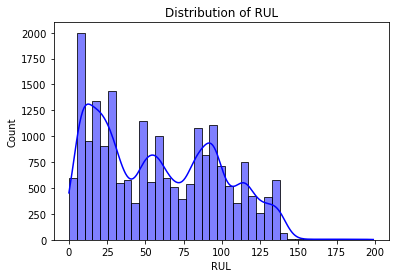

In [9]:
# Step 4: Exploratory Data Analysis (EDA)
sns.histplot(train_data['RUL'], kde=True, color='blue')
plt.title('Distribution of RUL')
plt.show()

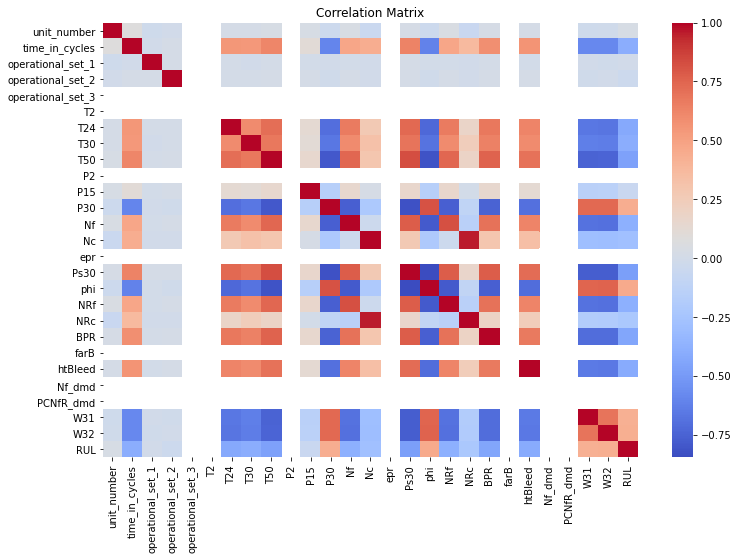

In [10]:
# Correlation Analysis
correlation_matrix = train_data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

ADF Statistic: -11.022910533676091
p-value: 5.925737535422655e-20


C:\Users\yalam\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


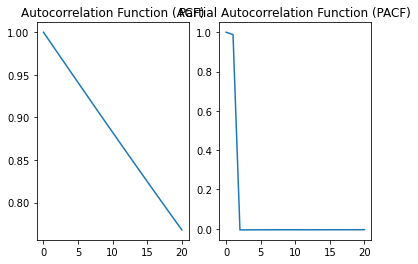

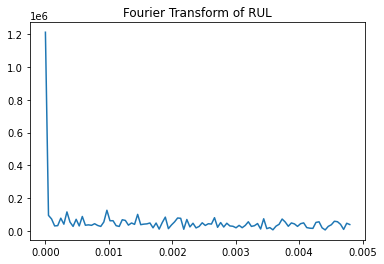

In [11]:
# Step 5: Time Series Analysis (Stationarity, ACF/PACF)
# ADF Test for Stationarity
result = adfuller(train_data['RUL'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

# ACF and PACF Plots
acf_values = acf(train_data['RUL'], nlags=20)
pacf_values = pacf(train_data['RUL'], nlags=20)

plt.subplot(121)
plt.plot(acf_values)
plt.title('Autocorrelation Function (ACF)')

plt.subplot(122)
plt.plot(pacf_values)
plt.title('Partial Autocorrelation Function (PACF)')

plt.show()

# Fourier Transform (to detect dominant frequencies)
fft_values = np.fft.fft(train_data['RUL'])
fft_freq = np.fft.fftfreq(len(train_data['RUL']))
plt.plot(fft_freq[:100], np.abs(fft_values)[:100])
plt.title('Fourier Transform of RUL')
plt.show()

In [12]:
# Step 6: Feature Engineering (Time-series Features)
# Create lag and rolling window features
def create_time_series_features(df):
    df['lag_1'] = df['RUL'].shift(1)
    df['rolling_mean_3'] = df['RUL'].rolling(3).mean()
    df['rolling_std_3'] = df['RUL'].rolling(3).std()
    df['rolling_mean_5'] = df['RUL'].rolling(5).mean()
    df['rolling_std_5'] = df['RUL'].rolling(5).std()
    return df

train_data = create_time_series_features(train_data)
train_data.fillna(0, inplace=True)

In [13]:
train_data.shape

(20631, 32)

In [14]:
# Step 7: Model Training (Linear, RandomForest, XGBoost)
X = train_data.drop(['unit_number', 'time_in_cycles', 'RUL'], axis=1)
y = train_data['RUL']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# 1. Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))

# 2. Random Forest
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))

# 3. XGBoost
xgb_model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))

Linear Regression RMSE: 1.7078537832600826
Random Forest RMSE: 1.516838929889876
XGBoost RMSE: 1.4605644598792387


In [15]:
# Deep Learning Models (LSTM, GRU, 1D CNN)
# Reshape data for LSTM/GRU/1D CNN (3D input)
X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# 1. LSTM Model
lstm_model = Sequential()
lstm_model.add(LSTM(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)
y_pred_lstm = lstm_model.predict(X_test_lstm)
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lstm)))

# 2. GRU Model
gru_model = Sequential()
gru_model.add(GRU(64, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])))
gru_model.add(Dropout(0.2))
gru_model.add(Dense(1))
gru_model.compile(optimizer=Adam(), loss='mean_squared_error')
gru_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32)
y_pred_gru = gru_model.predict(X_test_lstm)
print("GRU RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gru)))

Epoch 1/10
516/516 [==============================] - 3s 2ms/step - loss: 2575.1755
Epoch 2/10
516/516 [==============================] - 1s 2ms/step - loss: 491.6338
Epoch 3/10
516/516 [==============================] - 1s 2ms/step - loss: 267.3332
Epoch 4/10
516/516 [==============================] - 1s 2ms/step - loss: 166.5832
Epoch 5/10
516/516 [==============================] - 1s 2ms/step - loss: 105.3824
Epoch 6/10
516/516 [==============================] - 1s 2ms/step - loss: 73.6986
Epoch 7/10
516/516 [==============================] - 1s 1ms/step - loss: 61.9449
Epoch 8/10
516/516 [==============================] - 1s 2ms/step - loss: 57.3619
Epoch 9/10
516/516 [==============================] - 1s 2ms/step - loss: 51.3633
Epoch 10/10
129/129 [==============================] - 0s 1ms/step
LSTM RMSE: 2.731085604628045
Epoch 1/10
516/516 [==============================] - 2s 1ms/step - loss: 2579.1550
Epoch 2/10
516/516 [==============================] - 1s 1ms/step - loss: 39

In [16]:
# Comparing RMSE for all models
print("Model Comparison:")
print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("XGBoost RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_xgb)))
print("LSTM RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lstm)))
print("GRU RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gru)))

Model Comparison:
Linear Regression RMSE: 1.7078537832600826
Random Forest RMSE: 1.516838929889876
XGBoost RMSE: 1.4605644598792387
LSTM RMSE: 2.731085604628045
GRU RMSE: 2.2943062786428787


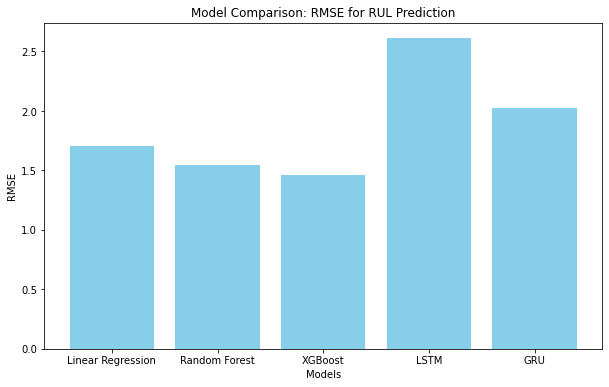

In [17]:
import matplotlib.pyplot as plt

# RMSE values for each model
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'LSTM', 'GRU']
rmse_values = [1.707, 1.542, 1.461, 2.612, 2.027]

# Plotting the RMSE values
plt.figure(figsize=(10, 6))
plt.bar(models, rmse_values, color='skyblue')
plt.title('Model Comparison: RMSE for RUL Prediction')
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.show()

In [ ]:
# ---- Hyperparameter Tuning for XGBoost ----
xgb_model = xgb.XGBRegressor()

# parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

# Perform Grid Search
xgb_grid_search = GridSearchCV(estimator=xgb_model, param_grid=xgb_param_grid, scoring='neg_mean_squared_error', cv=5)
xgb_grid_search.fit(X_train, y_train)

# Best Parameters and Model
print("Best Parameters for XGBoost:", xgb_grid_search.best_params_)
best_xgb_model = xgb_grid_search.best_estimator_

# Evaluate on test set
y_pred_xgb_tuned = best_xgb_model.predict(X_test)
xgb_rmse = np.sqrt(mean_squared_error(y_test, y_pred_xgb_tuned))
xgb_mae = mean_absolute_error(y_test, y_pred_xgb_tuned)
xgb_r2 = r2_score(y_test, y_pred_xgb_tuned)
xgb_mape = mean_absolute_percentage_error(y_test, y_pred_xgb_tuned)

In [41]:
print("Tuned XGBoost RMSE:", xgb_rmse)
print("Tuned XGBoost MAE:", xgb_mae)
print("Tuned XGBoost R²:", xgb_r2)

Tuned XGBoost RMSE: 1.4862889802858934
Tuned XGBoost MAE: 0.050200915434818624
Tuned XGBoost R²: 0.9986107564486474


In [ ]:
# ---- LSTM Model ----
# Assuming you have preprocessed the data for LSTM (X_train_lstm, X_test_lstm)
lstm_model = Sequential()
lstm_model.add(LSTM(128, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.3))
lstm_model.add(LSTM(64, activation='relu', return_sequences=False))
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(1))

# Compile the model
lstm_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = lstm_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, validation_data=(X_test_lstm, y_test))

# Evaluate the model
y_pred_lstm_tuned = lstm_model.predict(X_test_lstm)
lstm_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lstm_tuned))
lstm_mae = mean_absolute_error(y_test, y_pred_lstm_tuned)
lstm_r2 = r2_score(y_test, y_pred_lstm_tuned)
lstm_mape = mean_absolute_percentage_error(y_test, y_pred_lstm_tuned)

In [42]:
print("Refined LSTM RMSE:", lstm_rmse)
print("Refined LSTM MAE:", lstm_mae)
print("Refined LSTM R²:", lstm_r2)

Refined LSTM RMSE: 1.9764888007837473
Refined LSTM MAE: 0.9128068128335785
Refined LSTM R²: 0.9975432521219254


In [ ]:
# ---- GRU Model ----
gru_model = Sequential()
gru_model.add(GRU(128, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
gru_model.add(Dropout(0.3))
gru_model.add(GRU(64, activation='relu', return_sequences=False))
gru_model.add(Dropout(0.3))
gru_model.add(Dense(1))

# Compile the model
gru_model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model
history = gru_model.fit(X_train_lstm, y_train, epochs=50, batch_size=64, validation_data=(X_test_lstm, y_test))

# Evaluate the model
y_pred_gru_tuned = gru_model.predict(X_test_lstm)
gru_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gru_tuned))
gru_mae = mean_absolute_error(y_test, y_pred_gru_tuned)
gru_r2 = r2_score(y_test, y_pred_gru_tuned)
gru_mape = mean_absolute_percentage_error(y_test, y_pred_gru_tuned)

In [43]:
print("Refined GRU RMSE:", gru_rmse)
print("Refined GRU MAE:", gru_mae)
print("Refined GRU R²:", gru_r2)

Refined GRU RMSE: 2.196689458536303
Refined GRU MAE: 1.2147974456110502
Refined GRU R²: 0.9969653458311751


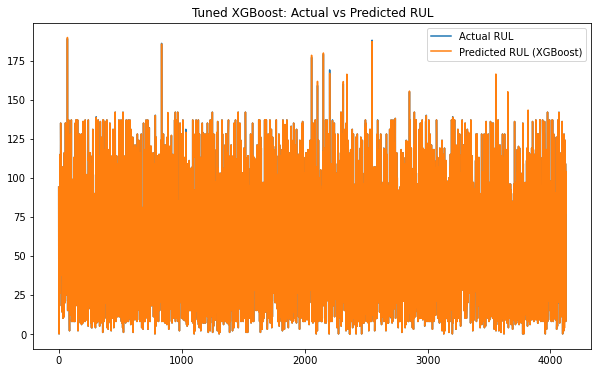

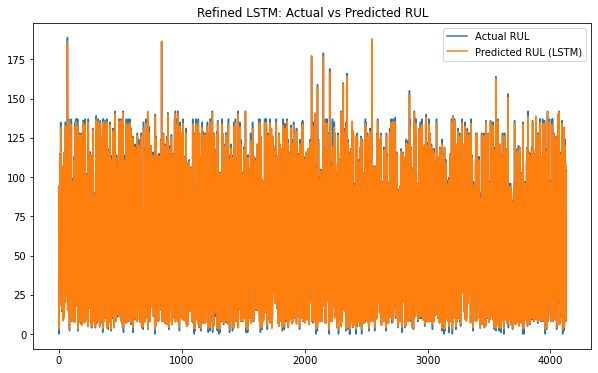

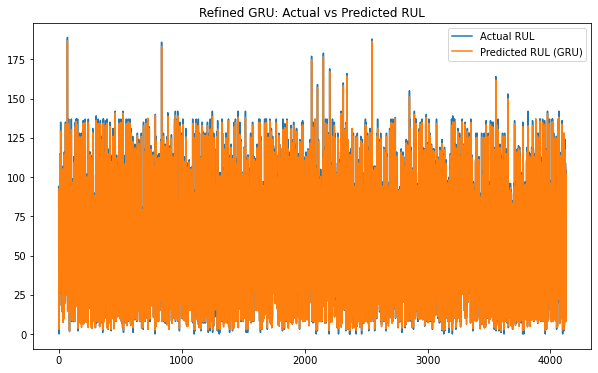

In [21]:
# ---- Visualization: Actual vs Predicted ----
# Plotting Actual vs Predicted for each model

# XGBoost
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual RUL')
plt.plot(y_pred_xgb_tuned, label='Predicted RUL (XGBoost)')
plt.title('Tuned XGBoost: Actual vs Predicted RUL')
plt.legend()
plt.show()

# LSTM
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual RUL')
plt.plot(y_pred_lstm_tuned, label='Predicted RUL (LSTM)')
plt.title('Refined LSTM: Actual vs Predicted RUL')
plt.legend()
plt.show()

# GRU
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual RUL')
plt.plot(y_pred_gru_tuned, label='Predicted RUL (GRU)')
plt.title('Refined GRU: Actual vs Predicted RUL')
plt.legend()
plt.show()

In [44]:
# Alternative Models: CatBoost
from catboost import CatBoostRegressor
catboost_model = CatBoostRegressor()
catboost_model.fit(X_train, y_train)
y_pred_catboost = catboost_model.predict(X_test)
catboost_rmse = np.sqrt(mean_squared_error(y_test, y_pred_catboost))
print("CatBoost RMSE:", catboost_rmse)

Learning rate set to 0.063762
0:	learn: 37.4233311	total: 152ms	remaining: 2m 31s
1:	learn: 35.2015752	total: 157ms	remaining: 1m 18s
2:	learn: 33.0455250	total: 162ms	remaining: 53.7s
3:	learn: 31.0695768	total: 166ms	remaining: 41.3s
4:	learn: 29.2053009	total: 172ms	remaining: 34.2s
5:	learn: 27.5244544	total: 179ms	remaining: 29.6s
6:	learn: 25.9376729	total: 185ms	remaining: 26.3s
7:	learn: 24.4471181	total: 190ms	remaining: 23.6s
8:	learn: 23.0054137	total: 196ms	remaining: 21.6s
9:	learn: 21.6733879	total: 202ms	remaining: 20s
10:	learn: 20.3795607	total: 206ms	remaining: 18.6s
11:	learn: 19.1901381	total: 212ms	remaining: 17.5s
12:	learn: 18.0596915	total: 217ms	remaining: 16.5s
13:	learn: 16.9983147	total: 222ms	remaining: 15.6s
14:	learn: 16.0006279	total: 227ms	remaining: 14.9s
15:	learn: 15.0693153	total: 232ms	remaining: 14.3s
16:	learn: 14.1956071	total: 237ms	remaining: 13.7s
17:	learn: 13.3587872	total: 243ms	remaining: 13.2s
18:	learn: 12.6030964	total: 248ms	remaining

173:	learn: 0.6275977	total: 1.08s	remaining: 5.14s
174:	learn: 0.6244854	total: 1.09s	remaining: 5.13s
175:	learn: 0.6200581	total: 1.09s	remaining: 5.12s
176:	learn: 0.6198099	total: 1.1s	remaining: 5.11s
177:	learn: 0.6194827	total: 1.11s	remaining: 5.11s
178:	learn: 0.6177984	total: 1.11s	remaining: 5.11s
179:	learn: 0.6146561	total: 1.12s	remaining: 5.1s
180:	learn: 0.6110207	total: 1.12s	remaining: 5.08s
181:	learn: 0.6094286	total: 1.13s	remaining: 5.08s
182:	learn: 0.6092195	total: 1.13s	remaining: 5.06s
183:	learn: 0.6065635	total: 1.14s	remaining: 5.06s
184:	learn: 0.6024202	total: 1.15s	remaining: 5.05s
185:	learn: 0.6022150	total: 1.15s	remaining: 5.04s
186:	learn: 0.6002611	total: 1.16s	remaining: 5.03s
187:	learn: 0.5960707	total: 1.16s	remaining: 5.02s
188:	learn: 0.5932156	total: 1.17s	remaining: 5.01s
189:	learn: 0.5930465	total: 1.17s	remaining: 5s
190:	learn: 0.5903440	total: 1.18s	remaining: 4.99s
191:	learn: 0.5856279	total: 1.18s	remaining: 4.98s
192:	learn: 0.585

341:	learn: 0.3674475	total: 2s	remaining: 3.86s
342:	learn: 0.3664977	total: 2.01s	remaining: 3.85s
343:	learn: 0.3660335	total: 2.02s	remaining: 3.85s
344:	learn: 0.3646285	total: 2.04s	remaining: 3.87s
345:	learn: 0.3634314	total: 2.05s	remaining: 3.87s
346:	learn: 0.3625016	total: 2.05s	remaining: 3.86s
347:	learn: 0.3607734	total: 2.06s	remaining: 3.86s
348:	learn: 0.3604030	total: 2.06s	remaining: 3.85s
349:	learn: 0.3600317	total: 2.07s	remaining: 3.84s
350:	learn: 0.3597855	total: 2.08s	remaining: 3.84s
351:	learn: 0.3594118	total: 2.08s	remaining: 3.83s
352:	learn: 0.3583498	total: 2.08s	remaining: 3.82s
353:	learn: 0.3581594	total: 2.09s	remaining: 3.82s
354:	learn: 0.3579829	total: 2.1s	remaining: 3.81s
355:	learn: 0.3564309	total: 2.1s	remaining: 3.8s
356:	learn: 0.3558264	total: 2.11s	remaining: 3.8s
357:	learn: 0.3551926	total: 2.11s	remaining: 3.79s
358:	learn: 0.3546210	total: 2.12s	remaining: 3.78s
359:	learn: 0.3538873	total: 2.13s	remaining: 3.78s
360:	learn: 0.35278

520:	learn: 0.2506032	total: 3.09s	remaining: 2.85s
521:	learn: 0.2498806	total: 3.1s	remaining: 2.84s
522:	learn: 0.2492931	total: 3.11s	remaining: 2.83s
523:	learn: 0.2487211	total: 3.11s	remaining: 2.83s
524:	learn: 0.2477330	total: 3.12s	remaining: 2.82s
525:	learn: 0.2474002	total: 3.13s	remaining: 2.82s
526:	learn: 0.2465676	total: 3.13s	remaining: 2.81s
527:	learn: 0.2461211	total: 3.14s	remaining: 2.81s
528:	learn: 0.2457783	total: 3.15s	remaining: 2.8s
529:	learn: 0.2451676	total: 3.15s	remaining: 2.79s
530:	learn: 0.2449924	total: 3.16s	remaining: 2.79s
531:	learn: 0.2446104	total: 3.16s	remaining: 2.78s
532:	learn: 0.2440436	total: 3.17s	remaining: 2.77s
533:	learn: 0.2437105	total: 3.17s	remaining: 2.77s
534:	learn: 0.2431440	total: 3.18s	remaining: 2.76s
535:	learn: 0.2428887	total: 3.18s	remaining: 2.75s
536:	learn: 0.2424343	total: 3.19s	remaining: 2.75s
537:	learn: 0.2418490	total: 3.19s	remaining: 2.74s
538:	learn: 0.2412221	total: 3.2s	remaining: 2.73s
539:	learn: 0.2

699:	learn: 0.1898386	total: 4.17s	remaining: 1.78s
700:	learn: 0.1895466	total: 4.17s	remaining: 1.78s
701:	learn: 0.1892223	total: 4.18s	remaining: 1.77s
702:	learn: 0.1889004	total: 4.19s	remaining: 1.77s
703:	learn: 0.1885452	total: 4.2s	remaining: 1.76s
704:	learn: 0.1884415	total: 4.2s	remaining: 1.76s
705:	learn: 0.1882168	total: 4.21s	remaining: 1.75s
706:	learn: 0.1879606	total: 4.22s	remaining: 1.75s
707:	learn: 0.1878844	total: 4.22s	remaining: 1.74s
708:	learn: 0.1875744	total: 4.23s	remaining: 1.74s
709:	learn: 0.1874714	total: 4.23s	remaining: 1.73s
710:	learn: 0.1869561	total: 4.24s	remaining: 1.72s
711:	learn: 0.1867477	total: 4.25s	remaining: 1.72s
712:	learn: 0.1866586	total: 4.25s	remaining: 1.71s
713:	learn: 0.1865395	total: 4.26s	remaining: 1.71s
714:	learn: 0.1861830	total: 4.26s	remaining: 1.7s
715:	learn: 0.1859289	total: 4.27s	remaining: 1.69s
716:	learn: 0.1858095	total: 4.28s	remaining: 1.69s
717:	learn: 0.1855264	total: 4.28s	remaining: 1.68s
718:	learn: 0.1

879:	learn: 0.1507314	total: 5.24s	remaining: 715ms
880:	learn: 0.1506530	total: 5.25s	remaining: 709ms
881:	learn: 0.1503532	total: 5.25s	remaining: 703ms
882:	learn: 0.1500443	total: 5.26s	remaining: 697ms
883:	learn: 0.1498728	total: 5.27s	remaining: 691ms
884:	learn: 0.1496803	total: 5.27s	remaining: 685ms
885:	learn: 0.1494116	total: 5.28s	remaining: 679ms
886:	learn: 0.1492435	total: 5.28s	remaining: 673ms
887:	learn: 0.1491419	total: 5.29s	remaining: 667ms
888:	learn: 0.1486938	total: 5.29s	remaining: 661ms
889:	learn: 0.1485510	total: 5.3s	remaining: 655ms
890:	learn: 0.1484179	total: 5.3s	remaining: 649ms
891:	learn: 0.1483327	total: 5.31s	remaining: 643ms
892:	learn: 0.1481235	total: 5.31s	remaining: 637ms
893:	learn: 0.1477496	total: 5.32s	remaining: 631ms
894:	learn: 0.1477032	total: 5.32s	remaining: 624ms
895:	learn: 0.1475498	total: 5.33s	remaining: 618ms
896:	learn: 0.1473987	total: 5.33s	remaining: 612ms
897:	learn: 0.1471271	total: 5.34s	remaining: 606ms
898:	learn: 0.

In [46]:
# Ensemble of best 3 models
ensemble_pred = 0.5 * y_pred_catboost + 0.3 * y_pred_xgb + 0.2 * y_pred_lstm_tuned.flatten()
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_pred))
print("Ensemble RMSE:", ensemble_rmse)

Ensemble RMSE: 1.3199324433303175


In [47]:
# Hybrid LSTM + Tree Model
lstm_features = lstm_model.predict(X_train_lstm)
catboost_model.fit(lstm_features, y_train)
hybrid_pred = catboost_model.predict(lstm_model.predict(X_test_lstm))
hybrid_rmse = np.sqrt(mean_squared_error(y_test, hybrid_pred))
print("Hybrid Model RMSE:", hybrid_rmse)

516/516 [==============================] - 1s 1ms/step
Learning rate set to 0.063762
0:	learn: 37.3044468	total: 3.31ms	remaining: 3.31s
1:	learn: 35.0577082	total: 6.6ms	remaining: 3.29s
2:	learn: 32.9067064	total: 9.71ms	remaining: 3.23s
3:	learn: 30.8868640	total: 13.2ms	remaining: 3.29s
4:	learn: 29.0156494	total: 16.3ms	remaining: 3.24s
5:	learn: 27.2475718	total: 19.3ms	remaining: 3.2s
6:	learn: 25.5824609	total: 22.4ms	remaining: 3.17s
7:	learn: 24.0583939	total: 25.7ms	remaining: 3.19s
8:	learn: 22.5924480	total: 29.2ms	remaining: 3.22s
9:	learn: 21.2192814	total: 32.5ms	remaining: 3.22s
10:	learn: 19.9455784	total: 35.3ms	remaining: 3.17s
11:	learn: 18.7560139	total: 38ms	remaining: 3.13s
12:	learn: 17.6571004	total: 40.5ms	remaining: 3.07s
13:	learn: 16.6006587	total: 43.7ms	remaining: 3.08s
14:	learn: 15.6022652	total: 47.3ms	remaining: 3.11s
15:	learn: 14.6728303	total: 50.2ms	remaining: 3.09s
16:	learn: 13.8049579	total: 53.1ms	remaining: 3.07s
17:	learn: 12.9779701	total:

176:	learn: 1.6530217	total: 527ms	remaining: 2.45s
177:	learn: 1.6519993	total: 531ms	remaining: 2.45s
178:	learn: 1.6514833	total: 534ms	remaining: 2.45s
179:	learn: 1.6505510	total: 536ms	remaining: 2.44s
180:	learn: 1.6501631	total: 539ms	remaining: 2.44s
181:	learn: 1.6497379	total: 542ms	remaining: 2.44s
182:	learn: 1.6486915	total: 545ms	remaining: 2.43s
183:	learn: 1.6484194	total: 548ms	remaining: 2.43s
184:	learn: 1.6478659	total: 550ms	remaining: 2.42s
185:	learn: 1.6476249	total: 553ms	remaining: 2.42s
186:	learn: 1.6467193	total: 556ms	remaining: 2.42s
187:	learn: 1.6463043	total: 558ms	remaining: 2.41s
188:	learn: 1.6460304	total: 561ms	remaining: 2.41s
189:	learn: 1.6454844	total: 564ms	remaining: 2.4s
190:	learn: 1.6444123	total: 566ms	remaining: 2.4s
191:	learn: 1.6435411	total: 569ms	remaining: 2.4s
192:	learn: 1.6430506	total: 572ms	remaining: 2.39s
193:	learn: 1.6421639	total: 575ms	remaining: 2.39s
194:	learn: 1.6418578	total: 577ms	remaining: 2.38s
195:	learn: 1.6

359:	learn: 1.6008151	total: 1.05s	remaining: 1.88s
360:	learn: 1.6006379	total: 1.06s	remaining: 1.87s
361:	learn: 1.6005991	total: 1.06s	remaining: 1.87s
362:	learn: 1.6004531	total: 1.06s	remaining: 1.87s
363:	learn: 1.6003408	total: 1.07s	remaining: 1.86s
364:	learn: 1.6002962	total: 1.07s	remaining: 1.86s
365:	learn: 1.6002716	total: 1.07s	remaining: 1.86s
366:	learn: 1.6001144	total: 1.08s	remaining: 1.86s
367:	learn: 1.6000275	total: 1.08s	remaining: 1.86s
368:	learn: 1.5999208	total: 1.09s	remaining: 1.86s
369:	learn: 1.5998063	total: 1.09s	remaining: 1.85s
370:	learn: 1.5997614	total: 1.09s	remaining: 1.85s
371:	learn: 1.5996395	total: 1.1s	remaining: 1.85s
372:	learn: 1.5995653	total: 1.1s	remaining: 1.85s
373:	learn: 1.5994583	total: 1.1s	remaining: 1.85s
374:	learn: 1.5992980	total: 1.11s	remaining: 1.84s
375:	learn: 1.5992303	total: 1.11s	remaining: 1.84s
376:	learn: 1.5992151	total: 1.11s	remaining: 1.84s
377:	learn: 1.5990588	total: 1.11s	remaining: 1.84s
378:	learn: 1.5

539:	learn: 1.5884340	total: 1.6s	remaining: 1.36s
540:	learn: 1.5884289	total: 1.6s	remaining: 1.36s
541:	learn: 1.5883816	total: 1.61s	remaining: 1.36s
542:	learn: 1.5883287	total: 1.61s	remaining: 1.36s
543:	learn: 1.5882754	total: 1.61s	remaining: 1.35s
544:	learn: 1.5882149	total: 1.62s	remaining: 1.35s
545:	learn: 1.5881770	total: 1.64s	remaining: 1.36s
546:	learn: 1.5881604	total: 1.64s	remaining: 1.36s
547:	learn: 1.5881113	total: 1.64s	remaining: 1.35s
548:	learn: 1.5880630	total: 1.65s	remaining: 1.35s
549:	learn: 1.5880106	total: 1.65s	remaining: 1.35s
550:	learn: 1.5879753	total: 1.65s	remaining: 1.35s
551:	learn: 1.5879438	total: 1.66s	remaining: 1.34s
552:	learn: 1.5879364	total: 1.66s	remaining: 1.34s
553:	learn: 1.5879270	total: 1.66s	remaining: 1.34s
554:	learn: 1.5878733	total: 1.67s	remaining: 1.34s
555:	learn: 1.5878214	total: 1.67s	remaining: 1.33s
556:	learn: 1.5878128	total: 1.67s	remaining: 1.33s
557:	learn: 1.5877975	total: 1.68s	remaining: 1.33s
558:	learn: 1.

714:	learn: 1.5835360	total: 2.15s	remaining: 855ms
715:	learn: 1.5835274	total: 2.15s	remaining: 852ms
716:	learn: 1.5835211	total: 2.15s	remaining: 849ms
717:	learn: 1.5834985	total: 2.15s	remaining: 846ms
718:	learn: 1.5834906	total: 2.16s	remaining: 843ms
719:	learn: 1.5834790	total: 2.16s	remaining: 841ms
720:	learn: 1.5834491	total: 2.16s	remaining: 838ms
721:	learn: 1.5834287	total: 2.17s	remaining: 835ms
722:	learn: 1.5834046	total: 2.17s	remaining: 831ms
723:	learn: 1.5833996	total: 2.17s	remaining: 828ms
724:	learn: 1.5833919	total: 2.18s	remaining: 825ms
725:	learn: 1.5833630	total: 2.18s	remaining: 823ms
726:	learn: 1.5833442	total: 2.18s	remaining: 819ms
727:	learn: 1.5833274	total: 2.19s	remaining: 816ms
728:	learn: 1.5833205	total: 2.19s	remaining: 813ms
729:	learn: 1.5833040	total: 2.19s	remaining: 810ms
730:	learn: 1.5832827	total: 2.19s	remaining: 807ms
731:	learn: 1.5832759	total: 2.2s	remaining: 804ms
732:	learn: 1.5832583	total: 2.2s	remaining: 801ms
733:	learn: 1.

892:	learn: 1.5814585	total: 2.68s	remaining: 321ms
893:	learn: 1.5814528	total: 2.68s	remaining: 318ms
894:	learn: 1.5814405	total: 2.68s	remaining: 315ms
895:	learn: 1.5814396	total: 2.69s	remaining: 312ms
896:	learn: 1.5814267	total: 2.69s	remaining: 309ms
897:	learn: 1.5814204	total: 2.69s	remaining: 306ms
898:	learn: 1.5814168	total: 2.7s	remaining: 303ms
899:	learn: 1.5813925	total: 2.7s	remaining: 300ms
900:	learn: 1.5813864	total: 2.7s	remaining: 297ms
901:	learn: 1.5813793	total: 2.71s	remaining: 294ms
902:	learn: 1.5813659	total: 2.71s	remaining: 291ms
903:	learn: 1.5813615	total: 2.71s	remaining: 288ms
904:	learn: 1.5813465	total: 2.71s	remaining: 285ms
905:	learn: 1.5813351	total: 2.72s	remaining: 282ms
906:	learn: 1.5813197	total: 2.72s	remaining: 279ms
907:	learn: 1.5813164	total: 2.72s	remaining: 276ms
908:	learn: 1.5813028	total: 2.73s	remaining: 273ms
909:	learn: 1.5812828	total: 2.73s	remaining: 270ms
910:	learn: 1.5812768	total: 2.73s	remaining: 267ms
911:	learn: 1.5

catboost alone stands as the best model across all !